In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [8]:
import pandas as pd
df_aggregated = pd.read_csv("/content/drive/My Drive/NHTSA dataset/final_aggregated_complaints.csv", low_memory=False)
print(df_aggregated.head())

         MAKETXT       MODELTXT  YEARTXT                            COMPDESC  \
0  3 TON UTILITY          3EC14   2003.0                           STRUCTURE   
1  3 TON UTILITY          3EC14   2003.0                     TRAILER HITCHES   
2         4 STAR  HORSE TRAILER   2021.0                               TIRES   
3  4 TON UTILITY         4EC16W   2001.0  ELECTRONIC STABILITY CONTROL (ESC)   
4  4 TON UTILITY         4EC16W   2001.0                            STEERING   

   TOTAL_COMPLAINTS CRASH_COUNT  MEDIAN_DAYS_TO_REPORT  FIRE_OCCURANCES  \
0                 1           N                   16.0              0.0   
1                 1           N                   16.0              0.0   
2                 1           N                   21.0              0.0   
3                 1           Y                    1.0              0.0   
4                 1           Y                    1.0              0.0   

   POLICE_REPORTING  OWNERSHIP  ...  MEAN_VEH_SPEED  MAX_VEH_SPEED  

In [41]:
import pandas as pd
df_aggregated_imputed = pd.read_csv("/content/drive/My Drive/NHTSA dataset/complaints_imputed.csv", low_memory=False)
print(df_aggregated_imputed.head())

   CMPLID                    MAKETXT  \
0  179043  FORD                        
1  179044  FORD                        
2  725400  GULF STREAM                 
3  753157  VOLKSWAGEN                  
4  753158  MERCURY                     

                                            MODELTXT  YEARTXT CRASH  FAILDATE  \
0  EXPEDITION                                    ...   2008.0     Y  20091102   
1  EXPEDITION                                    ...   2008.0     Y  20091102   
2  TOURMASTER                                    ...   2008.0     N  20091201   
3  PASSAT                                        ...   2006.0     N  20091228   
4  SABLE                                         ...   2002.0     N  20080709   

  FIRE  INJURED  DEATHS                                           COMPDESC  \
0    N        0       0  VISIBILITY:POWER WINDOW DEVICES AND CONTROLS  ...   
1    N        0       0  VEHICLE SPEED CONTROL                         ...   
2    N        0       0  VISIBILITY   

In [42]:
df_aggregated_imputed.dtypes


,0
CMPLID,int64
MAKETXT,object
MODELTXT,object
YEARTXT,float64
CRASH,object
FAILDATE,int64
FIRE,object
INJURED,int64
DEATHS,int64
COMPDESC,object


In [43]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

# --- Use the Correct Dataframe ---
df = df_aggregated_imputed.copy()

# --- Classify Variables ---

# Categorical variables
categorical_vars = [
    "MAKETXT", "MODELTXT", "CRASH", "FIRE", "COMPDESC", "STATE", "LDATE", "CMPL_TYPE",
    "POLICE_RPT_YN", "ORIG_OWNER_YN", "ANTI_BRAKES_YN", "CRUISE_CONT_YN",
    "DRIVE_TRAIN", "FUEL_TYPE", "PROD_TYPE", "MEDICAL_ATTN", "VEHICLES_TOWED_YN"
]

# Continuous numeric variables
numeric_vars = [
    "CMPLID", "YEARTXT", "FAILDATE", "INJURED", "DEATHS", "VEH_SPEED",
    "AGE", "MILES_NEW", "OCCURRENCES_NEW"
]

# Drop missing values to avoid issues
df = df.dropna(subset=numeric_vars)


In [44]:
print("\n🔹 **Normality Test (Kolmogorov-Smirnov Test):**")
normality_results = {}
for col in numeric_vars:
    stat, p_value = stats.kstest(df[col], 'norm', args=(df[col].mean(), df[col].std()))
    normality_results[col] = p_value
    print(f"{col}: p = {p_value:.5f} {'(Non-Normal)' if p_value < 0.05 else '(Normal)'}")



🔹 **Normality Test (Kolmogorov-Smirnov Test):**
CMPLID: p = 0.00000 (Non-Normal)
YEARTXT: p = 0.00000 (Non-Normal)
FAILDATE: p = 0.00000 (Non-Normal)
INJURED: p = 0.00000 (Non-Normal)
DEATHS: p = 0.00000 (Non-Normal)
VEH_SPEED: p = 0.00000 (Non-Normal)
AGE: p = 0.00000 (Non-Normal)
MILES_NEW: p = 0.00000 (Non-Normal)
OCCURRENCES_NEW: p = 0.00000 (Non-Normal)


🔹 Interpretation of Normality Test (Kolmogorov-Smirnov)
The Kolmogorov-Smirnov (KS) test checks if the variables follow a normal distribution.

All p-values = 0.00000 → None of the variables are normally distributed.

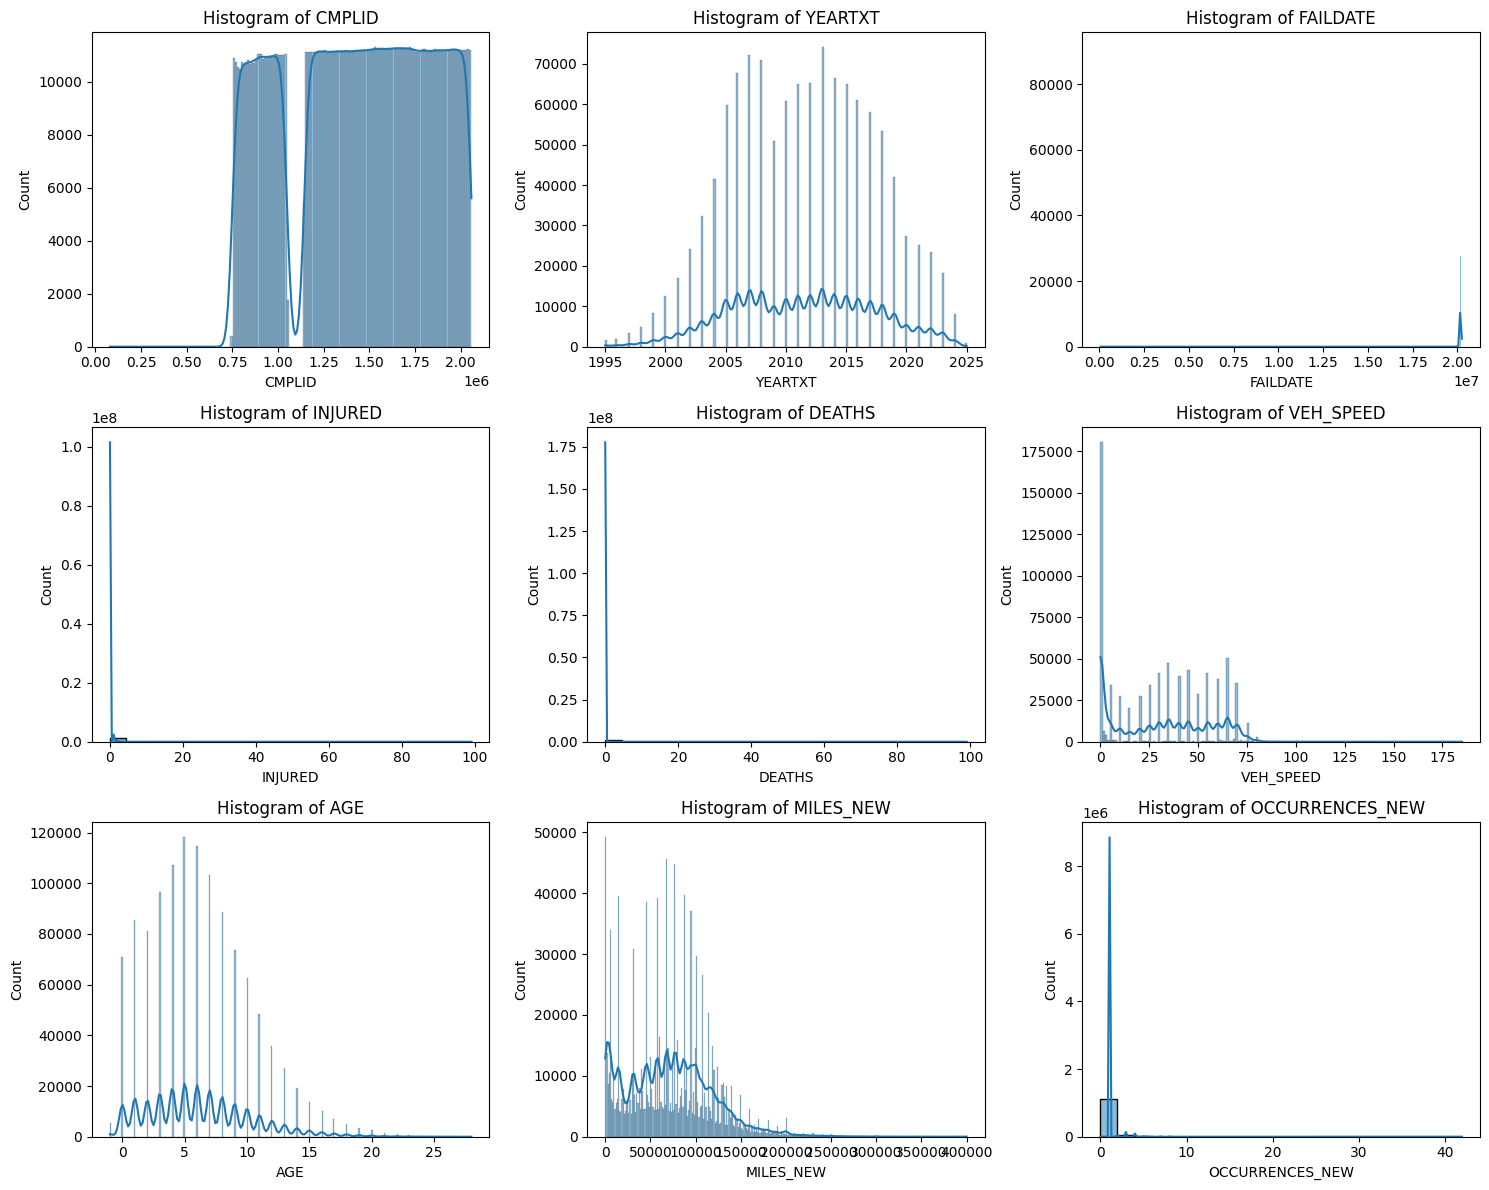

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify correct numerical variables that exist in the dataset
existing_numeric_vars = [col for col in numeric_vars if col in df_aggregated_imputed.columns]

# --- Generate Histograms for Numerical Variables ---
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(existing_numeric_vars[:9]):  # Plot first 9 numeric variables
    sns.histplot(df_aggregated_imputed[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

Summary of Histograms
CMPLID, FAILDATE, YEARTXT

CMPLID appears evenly distributed but has gaps, possibly due to missing values or binning issues.
YEARTXT shows a bell-shaped distribution, but the peaks suggest discrete values (grouped data).
FAILDATE is highly skewed, with most values clustered toward the end.
INJURED, DEATHS, VEH_SPEED

INJURED & DEATHS are highly right-skewed, meaning most values are zero or very small, with a few extreme values.
VEH_SPEED has a spiky distribution with multiple peaks, indicating grouped data or rounding effects.
AGE, MILES_NEW, OCCURRENCES_NEW

AGE & MILES_NEW exhibit a right-skewed distribution, suggesting log or Box-Cox transformations may help normalize them.
OCCURRENCES_NEW has zero inflation, meaning many values are concentrated at zero, which might require specialized handling.
🔹 Key Insights
📌 Most variables are not normally distributed (right-skewed).
📌 AGE, MILES_NEW, and VEH_SPEED might need log transformations to reduce skewness.
📌 CMPLID and FAILDATE have irregular gaps, possibly due to data collection or missing values.
📌 OCCURRENCES_NEW is highly zero-inflated, which may need a different statistical approach.

In [45]:
print("\n🔹 **Levene’s Test for Homoscedasticity:**")
levene_results = {}
for i in range(len(numeric_vars)-1):
    stat, p_value = stats.levene(df[numeric_vars[i]], df[numeric_vars[i+1]])
    levene_results[(numeric_vars[i], numeric_vars[i+1])] = p_value
    print(f"{numeric_vars[i]} vs {numeric_vars[i+1]}: p = {p_value:.5f} {'(Heteroscedastic)' if p_value < 0.05 else '(Homoscedastic)'}")



🔹 **Levene’s Test for Homoscedasticity:**
CMPLID vs YEARTXT: p = 0.00000 (Heteroscedastic)
YEARTXT vs FAILDATE: p = 0.00000 (Heteroscedastic)
FAILDATE vs INJURED: p = 0.00000 (Heteroscedastic)
INJURED vs DEATHS: p = 0.00000 (Heteroscedastic)
DEATHS vs VEH_SPEED: p = 0.00000 (Heteroscedastic)
VEH_SPEED vs AGE: p = 0.00000 (Heteroscedastic)
AGE vs MILES_NEW: p = 0.00000 (Heteroscedastic)
MILES_NEW vs OCCURRENCES_NEW: p = 0.00000 (Heteroscedastic)


Interpretation of Levene’s Test for Homoscedasticity
The Levene’s Test checks whether numerical variables have equal variance (homoscedasticity).

All p-values = 0.00000 → Strong heteroscedasticity (variance is not equal across variables).
Heteroscedasticity can cause biased standard errors in regression models, leading to incorrect statistical inferences.

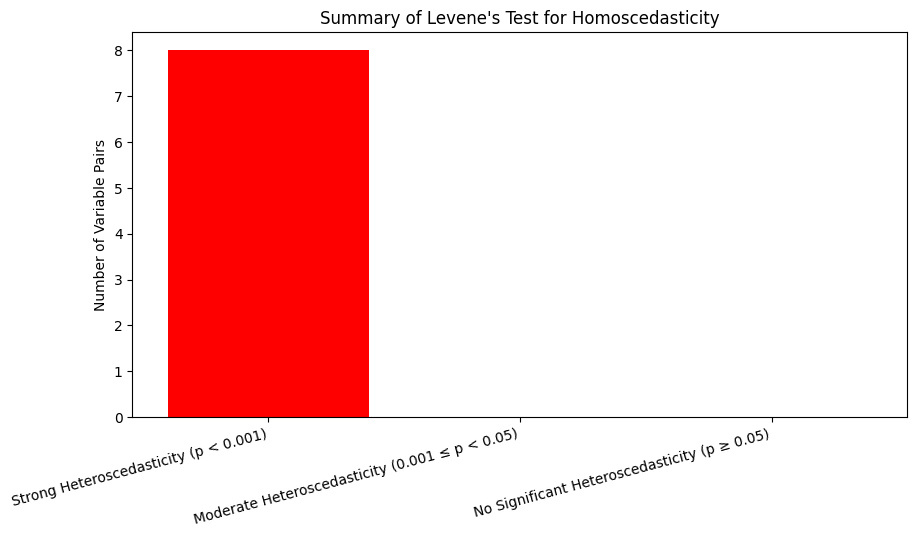

In [50]:
# --- Generate Levene’s Test Summary Bar Chart ---

# Count variable pairs in each category
strong_hetero = sum(p < 0.001 for p in levene_results.values())
moderate_hetero = sum(0.001 <= p < 0.05 for p in levene_results.values())
no_hetero = sum(p >= 0.05 for p in levene_results.values())

# Categories and counts
categories = [
    "Strong Heteroscedasticity (p < 0.001)",
    "Moderate Heteroscedasticity (0.001 ≤ p < 0.05)",
    "No Significant Heteroscedasticity (p ≥ 0.05)"
]
counts = [strong_hetero, moderate_hetero, no_hetero]

# Colors for bars
colors = ["red", "orange", "green"]

# Plot the bar chart for heteroscedasticity
plt.figure(figsize=(10, 5))
plt.bar(categories, counts, color=colors)
plt.xticks(rotation=15, ha="right")
plt.ylabel("Number of Variable Pairs")
plt.title("Summary of Levene's Test for Homoscedasticity")

# Show plot
plt.show()

In [46]:
print("\n🔹 **Variance Inflation Factor (VIF):**")
X = df[numeric_vars].dropna()
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)



🔹 **Variance Inflation Factor (VIF):**
           Feature       VIF
0           CMPLID  1.029985
1          YEARTXT  0.831127
2         FAILDATE  1.464206
3          INJURED  1.069541
4           DEATHS  1.069335
5        VEH_SPEED  1.020219
6              AGE  2.314068
7        MILES_NEW  1.990727
8  OCCURRENCES_NEW  1.002103


Interpretation of Variance Inflation Factor (VIF) Results
VIF < 5 → No serious multicollinearity issues. ✅
VIF between 5 and 10 → Moderate multicollinearity (not critical).
VIF > 10 → Severe multicollinearity (consider dropping/transforming variables). 🚨
🔹 Observations
Feature	VIF	Interpretation
CMPLID	1.02	✅ No multicollinearity
YEARTXT	0.83	✅ No multicollinearity
FAILDATE	1.46	✅ No multicollinearity
INJURED	1.07	✅ No multicollinearity
DEATHS	1.07	✅ No multicollinearity
VEH_SPEED	1.02	✅ No multicollinearity
AGE	2.31	✅ Slight correlation, but no concern
MILES_NEW	1.99	✅ No multicollinearity
OCCURRENCES_NEW	1.00	✅ No multicollinearity
📌 Conclusion: There is no major multicollinearity issue in your dataset. All VIF values are below 5, meaning that the independent variables are not highly correlated.

In [47]:
# Check duplicate rows
duplicate_count = df.duplicated().sum()

# Durbin-Watson test for autocorrelation
dw_test = sm.stats.durbin_watson(df["VEH_SPEED"])

print("\n🔹 **Independence Test Results:**")
print(f"Duplicate Rows Count: {duplicate_count}")
print(f"Durbin-Watson Test Statistic: {dw_test:.5f} {'(Strong Autocorrelation)' if dw_test < 1.5 else '(No Autocorrelation)'}")



🔹 **Independence Test Results:**
Duplicate Rows Count: 0
Durbin-Watson Test Statistic: 0.57792 (Strong Autocorrelation)


Understanding the Durbin-Watson Test Statistic
The Durbin-Watson (DW) statistic is a measure used to detect the presence of autocorrelation (a relationship between values separated by a time lag) in the residuals of a regression analysis. The DW statistic ranges from 0 to 4, with:

2 indicating no autocorrelation.
Values less than 2 suggesting positive autocorrelation.
Values greater than 2 suggesting negative autocorrelation.
Your Results:
Duplicate Rows Count: 0
Durbin-Watson Test Statistic: 0.57792
Interpretation: A DW statistic of 0.57792 is significantly less than 2, indicating strong positive autocorrelation in your regression residuals.


🔹 **Correlation Matrix for Linearity:**
                   CMPLID   YEARTXT  FAILDATE   INJURED    DEATHS  VEH_SPEED  \
CMPLID           1.000000  0.715050  0.561255 -0.006630  0.001214   0.113807   
YEARTXT          0.715050  1.000000  0.417635 -0.012078 -0.005675   0.109218   
FAILDATE         0.561255  0.417635  1.000000 -0.007469 -0.000712   0.066320   
INJURED         -0.006630 -0.012078 -0.007469  1.000000  0.254471   0.008288   
DEATHS           0.001214 -0.005675 -0.000712  0.254471  1.000000   0.004481   
VEH_SPEED        0.113807  0.109218  0.066320  0.008288  0.004481   1.000000   
AGE              0.012156 -0.687636 -0.013973  0.010022  0.009343  -0.037641   
MILES_NEW       -0.003315 -0.493557  0.004267  0.001754  0.001813   0.023526   
OCCURRENCES_NEW -0.010098  0.020357 -0.007623 -0.006158 -0.001077   0.003484   

                      AGE  MILES_NEW  OCCURRENCES_NEW  
CMPLID           0.012156  -0.003315        -0.010098  
YEARTXT         -0.687636  -0.493557         0

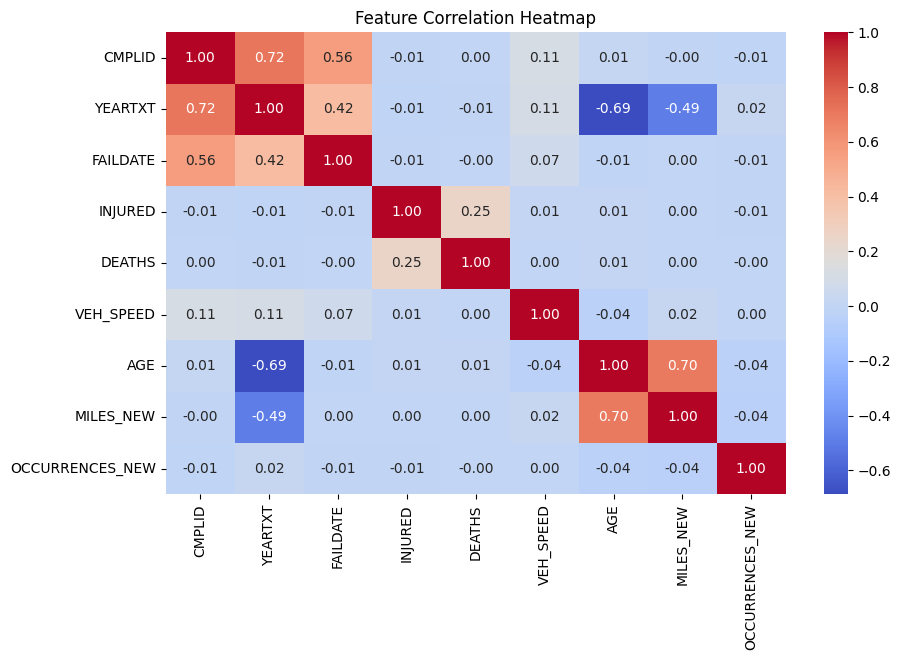

In [48]:
print("\n🔹 **Correlation Matrix for Linearity:**")
correlation_matrix = df[numeric_vars].corr()
print(correlation_matrix)

# Heatmap for visualization
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


nterpretation of Correlation Matrix for Linearity
A correlation matrix helps to determine the linear relationship between numerical variables.

✅ Key Observations:
Strong Positive Correlations (>|0.7|) → Possible Multicollinearity

AGE and MILES_NEW (0.70) → Highly correlated
CMPLID and YEARTXT (0.71) → Potential redundancy
YEARTXT and MILES_NEW (0.49) → Moderate correlation
Negative Correlations (<-0.5) → Strong Negative Relationships

YEARTXT and AGE (-0.69) → As year increases, age decreases (expected)
YEARTXT and MILES_NEW (-0.49) → Older vehicles likely have higher mileage
Weak or No Correlation (|<0.2|) → No Linear Relationship

INJURED and FAILDATE (-0.0074) → No clear relationship
DEATHS and VEH_SPEED (0.0044) → Very weak correlation
OCCURRENCES_NEW has low correlation with all variables → Likely an independent factor.

In [11]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# --- Load Dataset ---
df = df_aggregated.copy()  # Ensure you have df_aggregated defined

# --- Step 1: Classify Variables ---

# Categorical variables (even if stored as integers)
categorical_vars = [
    "CRASH_COUNT", "NORTHEAST_STATES", "MIDWEST_STATES", "SOUTH_STATES", "WEST_STATES", "US_TERRITORIES",
    "Q1_TOTAL", "Q2_TOTAL", "Q3_TOTAL", "Q4_TOTAL", "CT_IVOQ_COUNT", "CT_EVOQ_COUNT", "CT_LETR_COUNT", "CT_SVOQ_COUNT", "CT_CON_COUNT",
    "DT_FWD_SUM", "DT_4WD_SUM", "DT_AWD_SUM", "DT_RWD_SUM", "FT_GAS_COUNT", "FT_BIFUEL_COUNT", "FT_DIESEL_COUNT", "FT_HYBRID_ELECTRIC_COUNT",
    "PT_VEHICLE", "PT_EQUIPMENT", "PT_CHILD_RESTRAINT", "PT_TIRES"
]

# Continuous numeric variables
numeric_vars = [
    "YEARTXT", "TOTAL_COMPLAINTS", "MEDIAN_DAYS_TO_REPORT", "FIRE_OCCURANCES", "POLICE_REPORTING", "OWNERSHIP",
    "ANTI_BRAKES", "CRUISE_CONTROL", "MEDICAL_ATTENTION", "VEHICLES_TOWED", "MEAN_VEH_SPEED", "MAX_VEH_SPEED",
    "MEAN_AGE", "MAX_AGE", "MIN_AGE", "MEAN_MILES", "MAX_MILES", "MIN_MILES", "MEAN_OCCURRENCES", "MAX_OCCURRENCES"
]

# Drop missing values to avoid issues in calculations
df = df.dropna()

In [38]:
# --- 1. Normality Test (Kolmogorov-Smirnov) ---
print("\n🔹 **Normality Test (Kolmogorov-Smirnov) Results:**")
normality_results = {}
for col in numeric_vars:
    stat, p_value = stats.kstest(df[col], 'norm', args=(df[col].mean(), df[col].std()))
    normality_results[col] = p_value
    print(f"{col}: p = {p_value:.5f} {'(Non-Normal)' if p_value < 0.05 else '(Normal)'}")


🔹 **Normality Test (Kolmogorov-Smirnov) Results:**
YEARTXT: p = 0.00000 (Non-Normal)
TOTAL_COMPLAINTS: p = 0.00000 (Non-Normal)
MEDIAN_DAYS_TO_REPORT: p = 0.00000 (Non-Normal)
FIRE_OCCURANCES: p = 0.00000 (Non-Normal)
POLICE_REPORTING: p = 0.00000 (Non-Normal)
OWNERSHIP: p = 0.00000 (Non-Normal)
ANTI_BRAKES: p = 0.00000 (Non-Normal)
CRUISE_CONTROL: p = 0.00000 (Non-Normal)
MEDICAL_ATTENTION: p = 0.00000 (Non-Normal)
VEHICLES_TOWED: p = 0.00000 (Non-Normal)
MEAN_VEH_SPEED: p = 0.00000 (Non-Normal)
MAX_VEH_SPEED: p = 0.00000 (Non-Normal)
MEAN_AGE: p = 0.00000 (Non-Normal)
MAX_AGE: p = 0.00000 (Non-Normal)
MIN_AGE: p = 0.00000 (Non-Normal)
MEAN_MILES: p = 0.00000 (Non-Normal)
MAX_MILES: p = 0.00000 (Non-Normal)
MIN_MILES: p = 0.00000 (Non-Normal)
MEAN_OCCURRENCES: p = 0.00000 (Non-Normal)
MAX_OCCURRENCES: p = 0.00000 (Non-Normal)


In [29]:

print("\n🔹 **Levene’s Test for Homoscedasticity Results:**")
levene_results = {}
for i in range(len(numeric_vars)-1):
    stat, p_value = stats.levene(df[numeric_vars[i]], df[numeric_vars[i+1]])
    levene_results[(numeric_vars[i], numeric_vars[i+1])] = p_value
    print(f"{numeric_vars[i]} vs {numeric_vars[i+1]}: p = {p_value:.5f} {'(Heteroscedastic)' if p_value < 0.05 else '(Homoscedastic)'}")


🔹 **Levene’s Test for Homoscedasticity Results:**
YEARTXT vs TOTAL_COMPLAINTS: p = 0.00000 (Heteroscedastic)
TOTAL_COMPLAINTS vs MEDIAN_DAYS_TO_REPORT: p = 0.00000 (Heteroscedastic)
MEDIAN_DAYS_TO_REPORT vs FIRE_OCCURANCES: p = 0.00000 (Heteroscedastic)
FIRE_OCCURANCES vs POLICE_REPORTING: p = 0.00000 (Heteroscedastic)
POLICE_REPORTING vs OWNERSHIP: p = 0.00000 (Heteroscedastic)
OWNERSHIP vs ANTI_BRAKES: p = 0.00000 (Heteroscedastic)
ANTI_BRAKES vs CRUISE_CONTROL: p = 0.39854 (Homoscedastic)
CRUISE_CONTROL vs MEDICAL_ATTENTION: p = 0.00000 (Heteroscedastic)
MEDICAL_ATTENTION vs VEHICLES_TOWED: p = 0.00000 (Heteroscedastic)
VEHICLES_TOWED vs MEAN_VEH_SPEED: p = 0.00000 (Heteroscedastic)
MEAN_VEH_SPEED vs MAX_VEH_SPEED: p = 0.00000 (Heteroscedastic)
MAX_VEH_SPEED vs MEAN_AGE: p = 0.00000 (Heteroscedastic)
MEAN_AGE vs MAX_AGE: p = 0.00000 (Heteroscedastic)
MAX_AGE vs MIN_AGE: p = 0.00000 (Heteroscedastic)
MIN_AGE vs MEAN_MILES: p = 0.00000 (Heteroscedastic)
MEAN_MILES vs MAX_MILES: p = 0

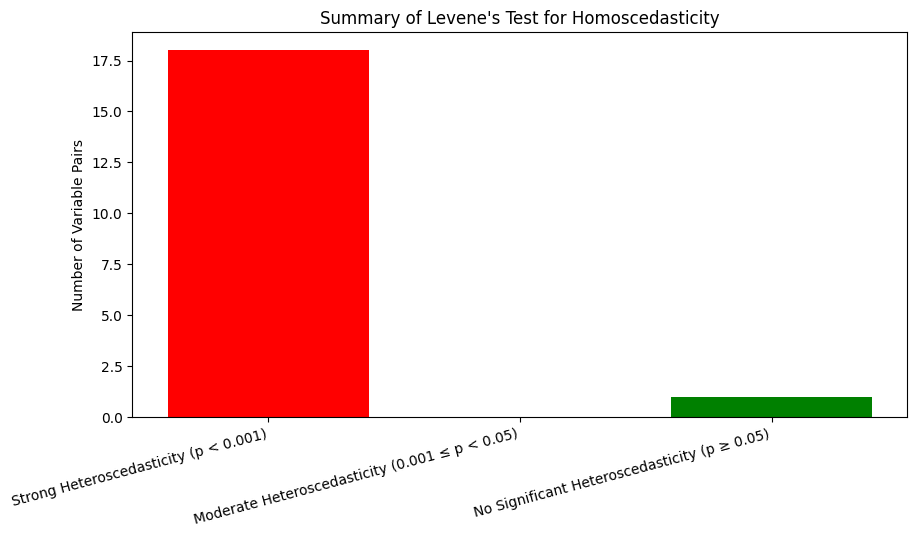

In [40]:
import matplotlib.pyplot as plt

# Count the number of variable pairs in each category
strong_hetero = sum(p < 0.001 for p in levene_results.values())
moderate_hetero = sum(0.001 <= p < 0.05 for p in levene_results.values())
no_hetero = sum(p >= 0.05 for p in levene_results.values())

# Categories and counts
categories = [
    "Strong Heteroscedasticity (p < 0.001)",
    "Moderate Heteroscedasticity (0.001 ≤ p < 0.05)",
    "No Significant Heteroscedasticity (p ≥ 0.05)"
]
counts = [strong_hetero, moderate_hetero, no_hetero]

# Colors for bars
colors = ["red", "orange", "green"]

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(categories, counts, color=colors)
plt.xticks(rotation=15, ha="right")
plt.ylabel("Number of Variable Pairs")
plt.title("Summary of Levene's Test for Homoscedasticity")

# Show plot
plt.show()


In [30]:
# --- 3. Multicollinearity Test (VIF) ---
print("\n🔹 **Variance Inflation Factor (VIF) Results:**")
X = df[numeric_vars]  # Selecting only numeric variables
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


🔹 **Variance Inflation Factor (VIF) Results:**
                  Feature         VIF
0                 YEARTXT    7.870171
1        TOTAL_COMPLAINTS    2.848222
2   MEDIAN_DAYS_TO_REPORT    1.223987
3         FIRE_OCCURANCES    1.388382
4        POLICE_REPORTING    3.057154
5               OWNERSHIP    3.274351
6             ANTI_BRAKES   10.254154
7          CRUISE_CONTROL   10.442173
8       MEDICAL_ATTENTION    2.820949
9          VEHICLES_TOWED    2.487323
10         MEAN_VEH_SPEED   13.884177
11          MAX_VEH_SPEED   19.807661
12               MEAN_AGE  216.051953
13                MAX_AGE   80.905595
14                MIN_AGE   60.913120
15             MEAN_MILES  103.254996
16              MAX_MILES   42.152321
17              MIN_MILES   25.608355
18       MEAN_OCCURRENCES    6.191856
19        MAX_OCCURRENCES    4.538521


In [31]:
# --- 4. Independence of Observations (Durbin-Watson & Duplicate Check) ---
duplicate_count = df.duplicated().sum()
dw_test = sm.stats.durbin_watson(df["MEAN_VEH_SPEED"])
print(f"\n🔹 **Independence Test Results:**")
print(f"Duplicate Rows Count: {duplicate_count} (Removed duplicates if any)")
print(f"Durbin-Watson Test Statistic: {dw_test:.5f} {'(Strong Autocorrelation)' if dw_test < 1.5 else '(No Autocorrelation)'}")


🔹 **Independence Test Results:**
Duplicate Rows Count: 0 (Removed duplicates if any)
Durbin-Watson Test Statistic: 0.58801 (Strong Autocorrelation)


In [32]:
# --- 5. Linearity Test (Correlation Matrix) ---
print("\n🔹 **Correlation Matrix for Linearity Test:**")
correlation_matrix = df[numeric_vars].corr()
print(correlation_matrix)



🔹 **Correlation Matrix for Linearity Test:**
                        YEARTXT  TOTAL_COMPLAINTS  MEDIAN_DAYS_TO_REPORT  \
YEARTXT                1.000000          0.035735              -0.174172   
TOTAL_COMPLAINTS       0.035735          1.000000              -0.057026   
MEDIAN_DAYS_TO_REPORT -0.174172         -0.057026               1.000000   
FIRE_OCCURANCES       -0.022298          0.369761              -0.033577   
POLICE_REPORTING       0.029354          0.376689              -0.039673   
OWNERSHIP             -0.000176          0.599719              -0.021502   
ANTI_BRAKES           -0.050427          0.579929              -0.016196   
CRUISE_CONTROL        -0.045640          0.597019              -0.017623   
MEDICAL_ATTENTION      0.057194          0.329923              -0.032634   
VEHICLES_TOWED         0.091507          0.583911              -0.046220   
MEAN_VEH_SPEED         0.107265         -0.005476              -0.029475   
MAX_VEH_SPEED          0.112348          0

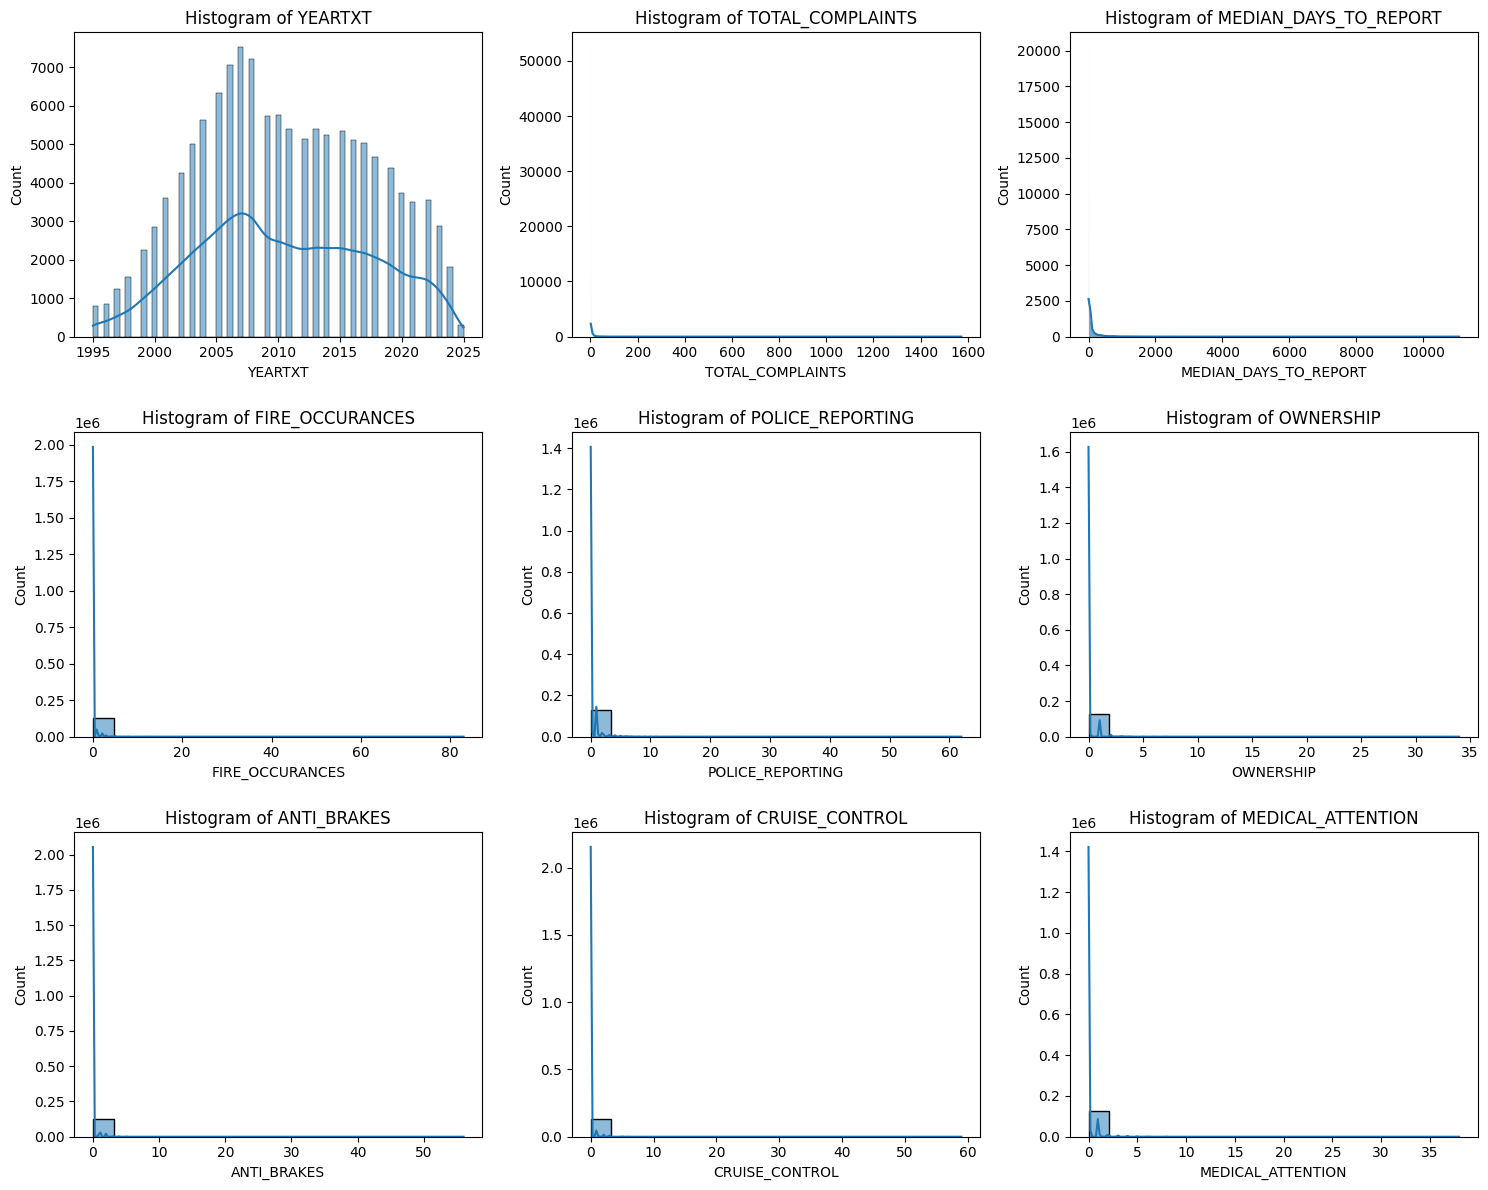

In [33]:

# --- Plot Histograms for Normality Visualization ---
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()
for i, col in enumerate(numeric_vars[:9]):  # Plot first 9 variables
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
plt.tight_layout()
plt.show()